In [25]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab9
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

# Other imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
import numpy as np
import math
import sys

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, RadioMaterial, LambertianPattern, watt_to_dbm
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft

In [2]:
scene = load_scene("blender/scene.xml")

In [3]:
polycarbonate = RadioMaterial("polycarbonate",
                              relative_permittivity=3,
                              conductivity=0.001,
                              scattering_coefficient=0.3,
                              xpd_coefficient=0.1,
                              scattering_pattern=LambertianPattern())

cardboard  = RadioMaterial("cardboard",
                           relative_permittivity=2.3,
                           conductivity=0.001,
                           scattering_coefficient=0.3,
                           xpd_coefficient=0.1,
                           scattering_pattern=LambertianPattern())

plastic = RadioMaterial("plastic",
                        relative_permittivity=2.8,
                        conductivity=0.0001,
                        scattering_coefficient=0.3,
                        xpd_coefficient=0.1,
                        scattering_pattern=LambertianPattern())

ceramic  = RadioMaterial("ceramic",
                         relative_permittivity=6,
                         conductivity=0.0001,
                         scattering_coefficient=0.3,
                         xpd_coefficient=0.1,
                         scattering_pattern=LambertianPattern())

In [4]:
Polycarbonate_parts = scene.get("Polycarbonate_parts")
Paper_boxes = scene.get("Paper_boxes") 
Plastic_parts = scene.get("Plastic_parts")  
Ceramic_parts = scene.get("Ceramic_parts")

In [5]:
Polycarbonate_parts.radio_material = polycarbonate 
Paper_boxes.radio_material = cardboard 
Plastic_parts.radio_material = plastic 
Ceramic_parts.radio_material = ceramic

In [6]:
scene.frequency = 60.48e9 # in Hz; implicitly updates RadioMaterials
scene.bandwidth = 512e6
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [7]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  512000000.0 [Hz]
Temperature:  293.0 [K]
Thermal noise power:  -86.83778 [dBm]


In [8]:
def angles(impulse_response, path_idx, angle_idx):
    if impulse_response[path_idx][angle_idx] < 0:
        impulse_response[path_idx][angle_idx] = 360 + impulse_response[path_idx][angle_idx]
        
    if impulse_response[path_idx][angle_idx] == 360:
        impulse_response[path_idx][angle_idx] = 0

In [9]:
def noise_CIR(tx_position, tx_power, filename):

    scene.remove("tx")
    scene.remove("tx_noise")
    scene.remove("rx")
    
    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.1,
                                 horizontal_spacing=0.1,
                                 pattern="iso",
                                 polarization="H")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1, 
                                 num_cols=1, 
                                 vertical_spacing=0.1,
                                 horizontal_spacing=0.1,
                                 pattern="iso",
                                 polarization="H")

    # Create transmitter
    tx = Transmitter(name="tx",
                     color=tf.Variable((1, 0, 0), dtype=tf.float32),
                     position=tx_position,
                     orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Create a receiver
    rx = Receiver(name="rx",
                  color=tf.Variable((1, 0, 0), dtype=tf.float32),
                  position=tf.Variable([4.2,2.5,1], dtype=tf.float32),
                  orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Add transmitter instance to scene
    scene.add(tx)

    # Add receiver instance to scene
    scene.add(rx)

    tx.look_at(rx) 
    rx.look_at(tx) 

    tx.power_dbm = tx_power

    paths = scene.compute_paths(max_depth=5,
                                num_samples=1e6)  
    
    paths.normalize_delays = False
    a, tau = paths.cir()
    all_paths = tau.shape[3]

    impulse_response = np.zeros((all_paths, 7))

    unit = 1 # 0 = rad, 1 = degree 

    for path_idx in range(all_paths):
        impulse_response[path_idx][0] = path_idx                                              # Path index
        impulse_response[path_idx][1] = np.abs(paths.a[0,0,0,0,0,path_idx, 0].numpy())        # Channel coefficient
        impulse_response[path_idx][2] = paths.tau[0,0,0,path_idx].numpy()                     # Propagation delay [s]
    
        if unit == 0:
            impulse_response[path_idx][3] = paths.theta_t[0,0,0,path_idx].numpy()             # Zenith angle of departure [rad]
            impulse_response[path_idx][4] = paths.phi_t[0,0,0,path_idx].numpy()               # Azimuth angle of departure [rad]
            impulse_response[path_idx][5] = paths.theta_r[0,0,0,path_idx].numpy()             # Zenith angle of arrival [rad]
            impulse_response[path_idx][6] = paths.phi_r[0,0,0,path_idx].numpy()               # Azimuth angle of arrival [rad]
            
        elif unit == 1:
            impulse_response[path_idx][3] = round(paths.theta_t[0,0,0,path_idx].numpy()*180/math.pi) # Zenith angle of departure [°]
            impulse_response[path_idx][4] = round(paths.phi_t[0,0,0,path_idx].numpy()*180/math.pi)   # Azimuth angle of departure [°]
            impulse_response[path_idx][5] = round(paths.theta_r[0,0,0,path_idx].numpy()*180/math.pi) # Zenith angle of arrival [°]
            impulse_response[path_idx][6] = round(paths.phi_r[0,0,0,path_idx].numpy()*180/math.pi)   # Azimuth angle of arrival [°]

        angles(impulse_response, path_idx, 3)
        angles(impulse_response, path_idx, 4)
        angles(impulse_response, path_idx, 5)
        angles(impulse_response, path_idx, 6)
    
    np.save(filename, impulse_response)

In [10]:
noise_CIR([6.1,2.5,1], 42, 'data/noise_simulation/tx.npy') # TX position
noise_CIR([8.3,4.7,1], 42, 'data/noise_simulation/noise1.npy') # noise position

In [11]:
CIR_TX = np.load('data/noise_simulation/tx.npy')
CIR_noise = np.load('data/noise_simulation/noise1.npy')

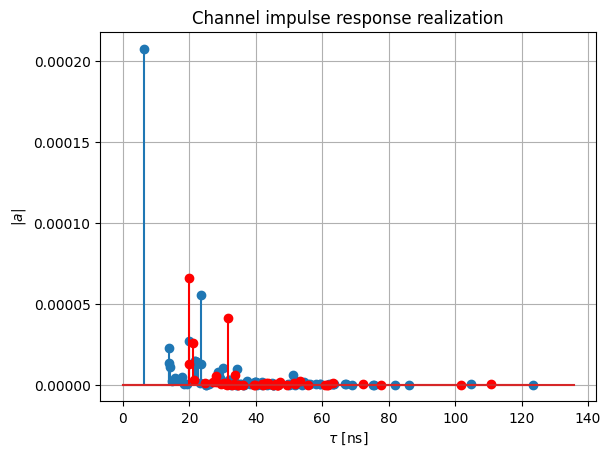

In [12]:
t = CIR_TX[:,2]/1e-9 # Scale to ns
a_abs = CIR_TX[:,1]
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

t2 = CIR_noise[:,2]/1e-9 # Scale to ns
a_abs2 = CIR_noise[:,1]
t2 = np.concatenate([(0.,), t2, (np.max(t2)*1.1,)])
a_abs2 = np.concatenate([(np.nan,), a_abs2, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.stem(t2, a_abs2,'r')
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");
plt.grid()

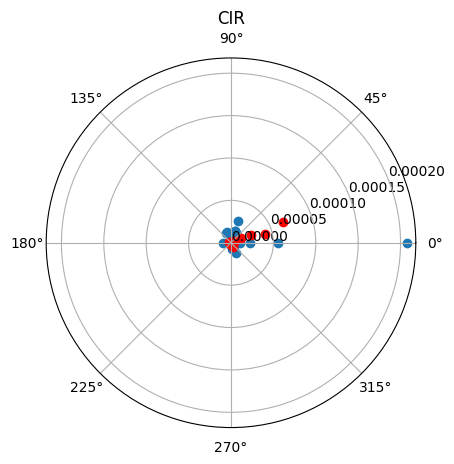

In [27]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.scatter(CIR_TX[:,6]*np.pi/180, CIR_TX[:,1])
ax.scatter(CIR_noise[:,6]*np.pi/180, CIR_noise[:,1], color='red')
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax.set_title("CIR arrival")
ax.grid(True)
plt.show()

In [13]:
def coverage_map_fnc(tx_position, noise_position, tx_orientation, noise_orientation, pattern, tx_power, noise_power, cm_height): 

    scene.remove("tx")
    scene.remove("tx_noise")
    scene.remove("rx")
    
    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #4
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #16
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Create transmitter
    tx = Transmitter(name="tx",
                 color=tf.Variable((1, 0, 0), dtype=tf.float32),
                 position=tx_position, 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Create noise transmitter
    tx_noise = Transmitter(name="tx_noise",
                 color=tf.Variable((0, 0, 1), dtype=tf.float32),
                 position=noise_position, 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))
    
    # Create a receiver
    rx = Receiver(name="rx",
              color=tf.Variable((1, 0, 0), dtype=tf.float32),
              position=tf.Variable([6.4,3,1], dtype=tf.float32),
              orientation=tf.Variable([0,0,0], dtype=tf.float32))
    
    # Add transmitter instances to scene
    scene.add(tx)
    scene.add(tx_noise)

    # Add receiver instance to scene
    scene.add(rx)

    tx.look_at(tx_orientation) 
    tx_noise.look_at(noise_orientation) 
    rx.look_at(tx) 

    tx.power_dbm = tx_power
    tx_noise.power_dbm = noise_power
    
    # Compute coverage map
    cm = scene.coverage_map(max_depth=5,           # Maximum number of ray scene interactions
                        num_samples=int(10e6), # If you increase: less noise, but more memory required
                        cm_cell_size=(0.1, 0.1),   # Resolution of the coverage map
                        cm_center=[5,2.5, cm_height],   # Center of the coverage map
                        cm_size=[11,6],    # Total size of the coverage map
                        cm_orientation=[0, 0, 0]) # Orientation of the coverage map, e.g., could be also vertical
    
    return cm

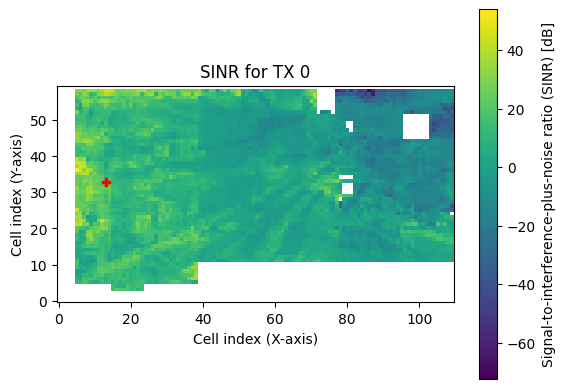

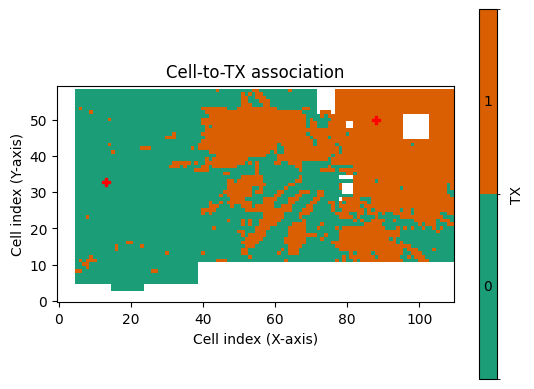

In [14]:
cm1 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm1.show(metric="sinr", tx=0);
cm1.show_association("rss");

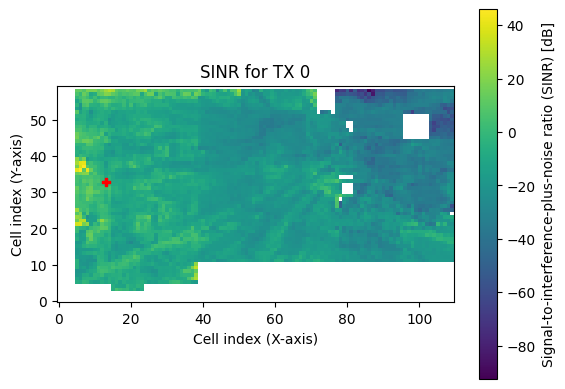

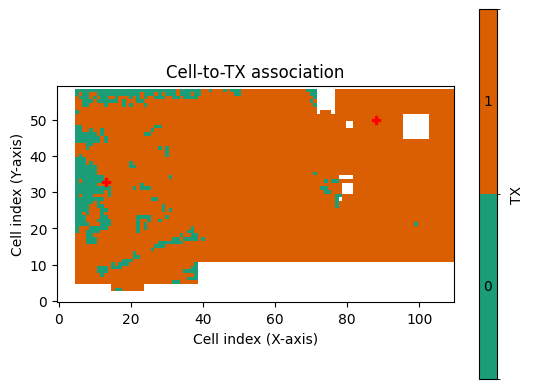

In [15]:
cm2 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 60, 
                      cm_height = 1)

cm2.show(metric="sinr", tx=0);
cm2.show_association("rss");

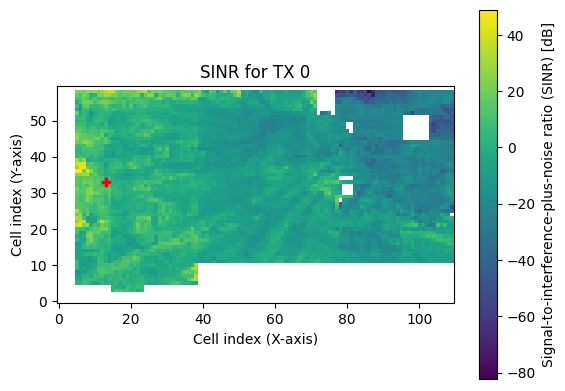

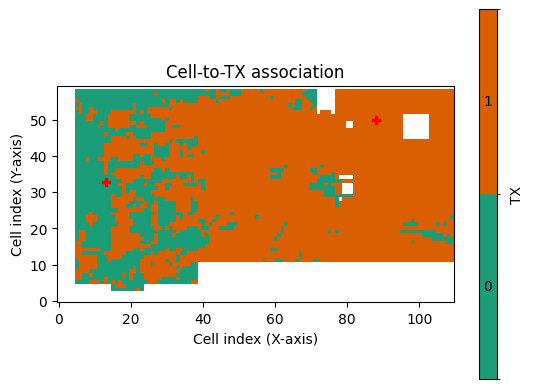

In [16]:
cm3 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 50, 
                      cm_height = 1)

cm3.show(metric="sinr", tx=0);
cm3.show_association("rss");

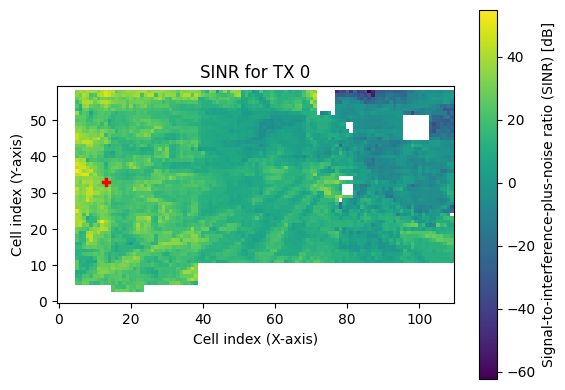

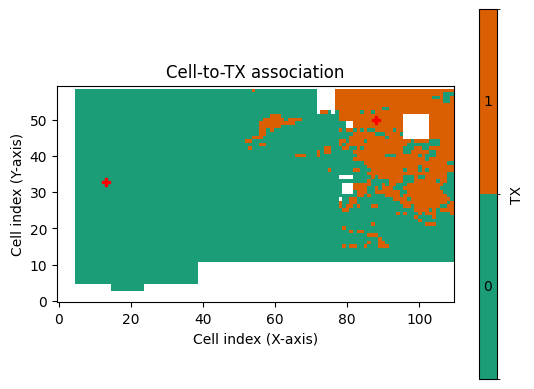

In [17]:
cm4 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 30, 
                      cm_height = 1)

cm4.show(metric="sinr", tx=0);
cm4.show_association("rss");

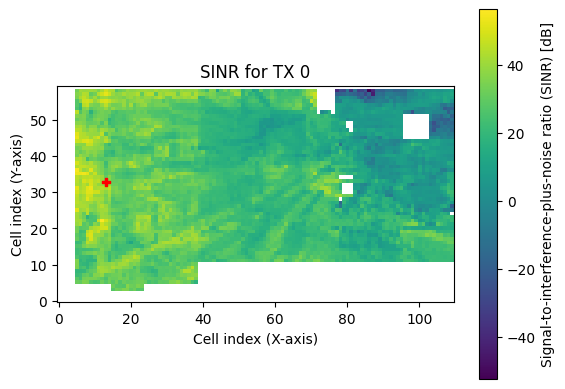

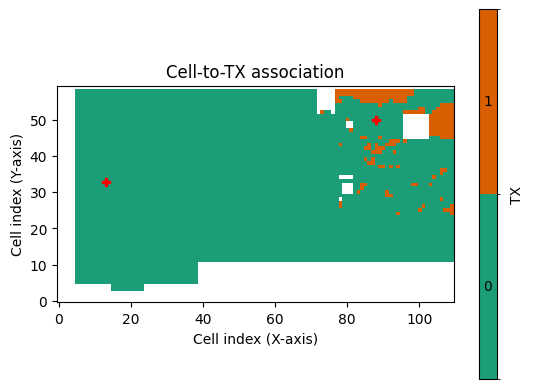

In [18]:
cm5 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 20, 
                      cm_height = 1)

cm5.show(metric="sinr", tx=0);
cm5.show_association("rss");

Position

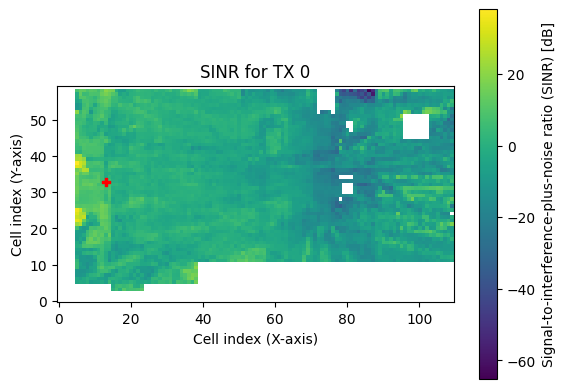

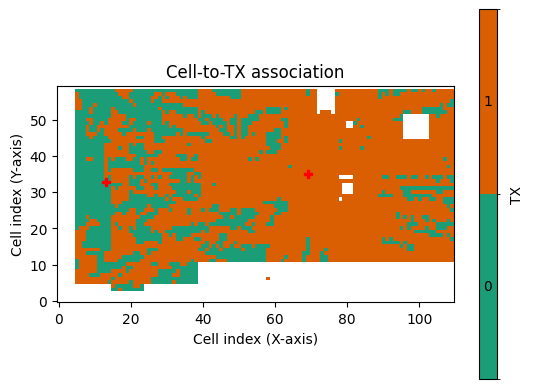

In [19]:
cm6 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [6.4,3,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm6.show(metric="sinr", tx=0);
cm6.show_association("rss");

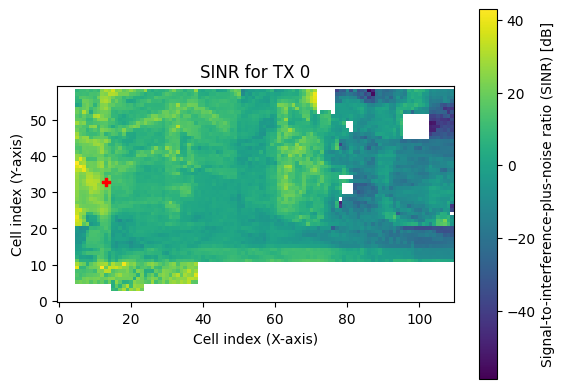

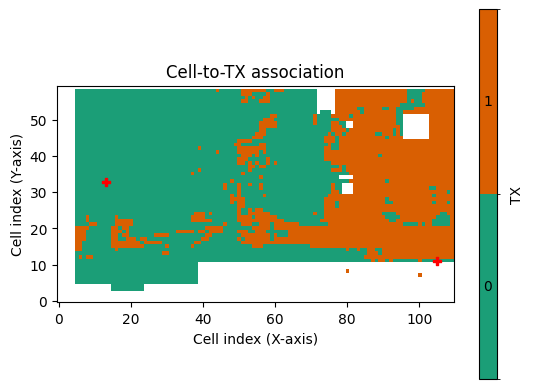

In [20]:
cm7 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [10,0.6,2.5], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm7.show(metric="sinr", tx=0);
cm7.show_association("rss");

Orientation

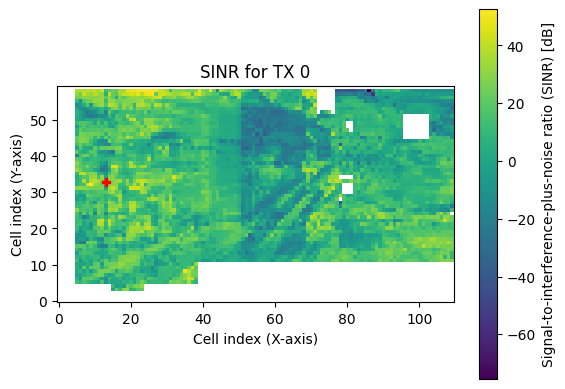

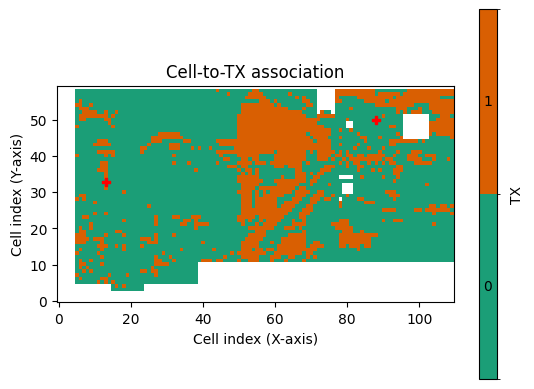

In [21]:
cm8 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,2.8,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm8.show(metric="sinr", tx=0);
cm8.show_association("rss");

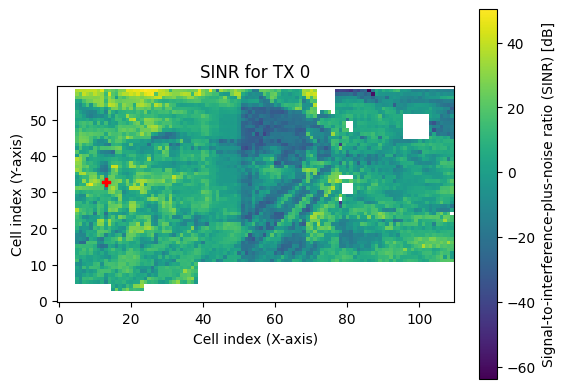

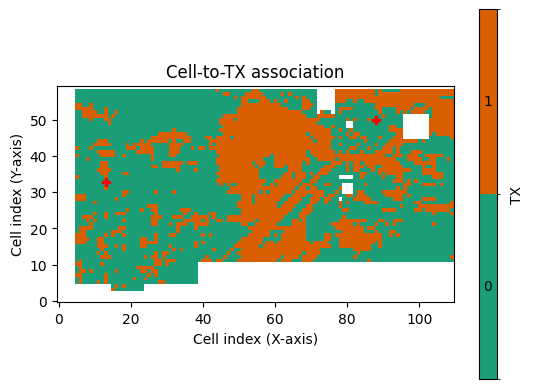

In [22]:
cm9 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,4,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm9.show(metric="sinr", tx=0);
cm9.show_association("rss");

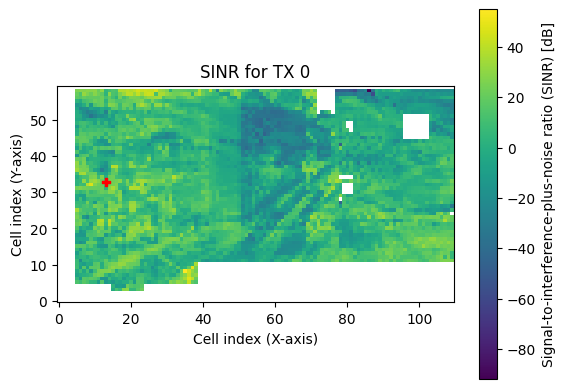

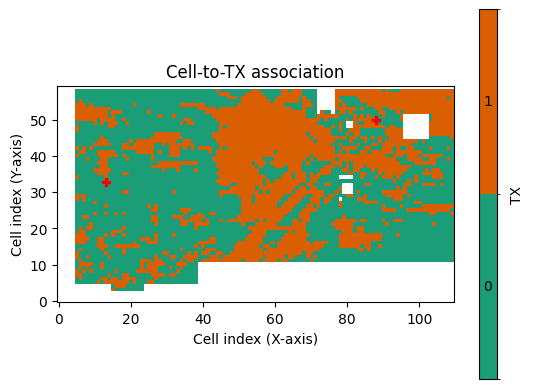

In [23]:
cm10 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,1.6,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm10.show(metric="sinr", tx=0);
cm10.show_association("rss");